<div>
    <h2><center>Global Glacier Velocity point Tracker</center></h2>
</div>

In [1]:
# Fetch the path for essential python scripts

import os
import sys
path =  os.getcwd()

# Import python scripts from notebooks folder
sys.path.append(path + '/scripts')

In [2]:
# Import all the necessary packages

%%capture
%matplotlib widget


UsageError: Line magic function `%%capture` not found.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import markdown 

matplotlib.rcParams['figure.figsize'] = [9, 5]
matplotlib.rcParams["figure.autolayout"] = True

from velocity_widget import ITSLIVE
velocity_widget = ITSLIVE()
plt.close()
from ipywidgets import widgets, HTML, Output
import xarray as xr
import numpy as np
import time
from pyproj import Transformer
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopandas as gpd
import ipyleaflet as ipl
import math
import pandas as pd
import glob
import seaborn

a:\System\Users\whisk\anaconda3\envs\pg7\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


### Instructions

This notebook will allow you to track pixels at the surface of your AOI, depending on their displacement from the velocity dataset ITS-LIVE.
**First:** choose the type of dataset you want to work with. Just make sure you already downloaded some data.
**Second:** select a date range. Make sure this range is at least the one you selected when you downloaded your data. It can be smaller if you want.



In [36]:
# Select the type of dataset you want to download: 'Yearly' or 'Daily'
type_dataset = "Daily"

# Select your date range (careful the datacubes get heavy quickly)
sdate = '2014-01-01'
edate = '2015-10-29'



#### Select approximately the area you want to work on (if you already have it downloaded)
This section should select automatically the data closest to your AOI.
Run the following cell.
Instructions: same as for data downloading for Yearly dataset:
- Left click once to put a marker
- Left click a second time to plot the AOI's boundaries.

In [37]:

dates_range = widgets.SelectionRangeSlider(
    options=[i for i in range(546)],
    index=(1, 120),
    continuous_update=False,
    description='Interval (days): ',
    orientation='horizontal',
    layout={'width': '90%',
            'display': 'flex'},
    style={'description_width': 'initial'})

variables =  widgets.Dropdown(
    options=['v', 'v_error', 'vx', 'vy'],
    description='Variable: ',
    disabled=False,
    value='v',
    layout={'width': '20%',
            'display': 'flex'},
    style={'description_width': 'initial'})

plot_type =  widgets.Dropdown(
    options=['location', 'satellite'],
    description='Plot By: ',
    disabled=False,
    value='location',
    layout={'width': '20%',
            'display': 'flex'},
    style={'description_width': 'initial'})

plot_button =  widgets.Button(
    description='Plot',
    button_style='primary',
    icon='line-chart',
    style={'description_width': 'initial'})

get_points =  widgets.Button(
    description='Get points',
    button_style='primary',
    icon='line-chart',
    style={'description_width': 'initial'})

clear_button =  widgets.Button(
    description='Clear Points',
    # button_style='warning',
    icon="trash",
    style={'description_width': 'initial'})

latitude = widgets.BoundedFloatText(
    value=0.0,
    min=-90.0,
    max=90.0,
    step=0.1,
    description='Lat: ',
    disabled=False,
    style={'description_width': 'initial'},
    layout={'width': '20%',
            'display': 'flex'},
)

longitude = widgets.BoundedFloatText(
    value=0.0,
    min=-180.0,
    max=180.0,
    step=0.1,
    description='Lon: ',
    disabled=False,
    style={'description_width': 'initial'},
    layout={'width': '20%',
            'display': 'flex'},
)

add_button =  widgets.Button(
    description='Add Point',
    # button_style='info',
    icon="map-marker",
    style={'description_width': 'initial'})

include_running_mean =  widgets.Checkbox(
            value=False,
            description="Include Running Mean",
            style={'description_width': 'initial'},
            disabled=False,
            indent=False,
            tooltip="Plot running mean through each time series",
            layout=widgets.Layout(width="25%"),
        )

export_button = widgets.Button(
    description='Export Data',
    # button_style='info',
    icon="file-export",
    style={'description_width': 'initial'})

data_link = widgets.HTML(
    value="<br>"
)

# If this congiguration changes we need to rerun the cell.
config = { 
    "plot": "v", # or other ITS_LIVE variables: vx, vy ...
    "min_separation_days": 1,
    "max_separation_days": 90,
    "color_by": "location", # valid values: satellite, points
    "verbose": True, # print operations
    "runnig_mean": True,
    "coords": {
        "latitude": latitude,
        "longitude": longitude
    },
    "data_link": data_link
}


def downloader(whatever):
    print('Downloading...')
    global pathsave
    ######### YEARLY DATASET DOWNLOAD ########
    if type_dataset == 'Yearly':

            # Create list of years for the date range chosen earlier
            list_years = np.arange(int(sdate.split('-')[0]), int(edate.split('-')[0])+1)

            # Create path to the files
            pathsave = velocity_widget.path_yearly_datacubes
            os.makedirs(pathsave, exist_ok = True)
            


            for Y in range(len(list_years)):

                    # Generate URL for the nc file
                    url = f'{velocity_widget.url_region[0]}{int(list_years[Y])}.nc#mode=bytes'

                    # Load datacube according to prerequisites (time, space and variables)
                    start = time.time()
                    xrds = xr.open_dataset(url
                                            ).sel(x=slice(velocity_widget.xmin_proj, velocity_widget.xmax_proj),
                                                y=slice(velocity_widget.ymax_proj, velocity_widget.ymin_proj)).load()

                    print(f"downloaded {list_years[Y]} spatial slice {time.time()-start:8.1f} seconds")
                    xrds.to_netcdf(f"{pathsave}{list_years[Y]}.nc")




    ######## DAILY DATASET DOWNLOAD ########
    else:

            # Create path to the files
            pathsave = velocity_widget.path_daily_datacubes
            os.makedirs(pathsave, exist_ok = True)

            # Get the cube address
            cubes = velocity_widget.dct.addresses
            cubes = [*set(cubes)]

            # List of variables to drop for the download (we drop everything but the variables written below)
            variables_drop = [ele for ele in list(
                    xr.open_dataset(cubes[0], engine='zarr').variables
                    ) if ele not in ['mid_date','x','y','acquisition_date_img1', 'acquisition_date_img2', 'date_center', 'date_dt', 'satellite_img1','satellite_img2', 'v','vx','vy','roi_valid_percentage']
            ]

            
            for n in range(len(cubes)):

                    # Get the cube's URL
                    url = cubes[n]

                    # Load indices of slices above the quality threshold
                    valid = xr.open_dataset(cubes[n], engine='zarr').roi_valid_percentage.values

                    # Grab the time values
                    t = xr.open_dataset(cubes[n], engine='zarr').mid_date.values

                    # Create a time mask, based on the validity of layers and the custom date-range
                    t_mask = np.logical_and(valid>threshold, np.logical_and(t>np.datetime64(sdate), t<np.datetime64(edate)))
                    
                    # Load datacube according to prerequisites (time, space and variables)
                    start = time.time()
                    xrds = xr.open_dataset(url,
                                            engine='zarr',
                                            drop_variables=variables_drop
                                            ).sel(mid_date=t_mask,
                                                x=slice(velocity_widget.xmin_proj, velocity_widget.xmax_proj),
                                                y=slice(velocity_widget.ymax_proj, velocity_widget.ymin_proj)).load()

                    print(f"downloaded {cubes[n].split('/')[-1].split('.')[0]} spatial slice {time.time()-start:8.1f} seconds")
                    xrds.to_netcdf(f"{pathsave}{cubes[n].split('/')[-1].split('.')[0]}_{sdate}_{edate}.nc")
    print('Done ! You can hit "plot" now')

def plotter(whatever):
    list_files = glob.glob(f'{pathsave}*.nc')

    fig, ax = plt.subplots(len(list_files), figsize=(10,10))

    if len(list_files) == 1:
        if type_dataset == "Yearly":
            ax.pcolormesh(xr.open_dataset(list_files[0]).x.values,xr.open_dataset(list_files[0]).y.values,xr.open_dataset(list_files[0]).v.values)
        else:
            ax.pcolormesh(xr.open_dataset(list_files[0]).x.values,xr.open_dataset(list_files[0]).y.values,np.nanmean(xr.open_dataset(list_files[0]).v.values,axis = 0))
    else:
        if type_dataset == "Yearly":
            for i in range(len(list_files)):
                ax[i].pcolormesh(xr.open_dataset(list_files[i]).x.values,xr.open_dataset(list_files[i]).y.values,xr.open_dataset(list_files[i]).v.values)
        else:
            for i in range(len(list_files)):
                ax[i].pcolormesh(xr.open_dataset(list_files[i]).x.values,xr.open_dataset(list_files[i]).y.values,np.nanmean(xr.open_dataset(list_files[i]).v.values,axis = 0))


def update_variable(change):
        if change['type'] == 'change' and change['name'] == 'value':
            config["plot"] = variables.value
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def update_range(change):
        if change['type'] == 'change' and change['name'] == 'value':
            start, end = change['new']
            config["min_separation_days"] = start
            config["max_separation_days"] = end
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def update_plottype(change):
        if change['type'] == 'change' and change['name'] == 'value':
            config["color_by"] = plot_type.value
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def update_mean(change):
        if change['type'] == 'change' and change['name'] == 'value':
            config["running_mean"] = include_running_mean.value
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def add_point(event):
    coords = (latitude.value, longitude.value)
    velocity_widget.add_point(coords)
    
def export_ts(event):
    velocity_widget.export_data()

get_points.on_click(velocity_widget.plot_time_series)
plot_button.on_click(plotter)
clear_button.on_click(velocity_widget.clear_points)

export_button.on_click(downloader)


add_button.on_click(add_point)
dates_range.observe(update_range, 'value')
plot_type.observe(update_plottype, 'value')
variables.observe(update_variable, 'value')
include_running_mean.observe(update_mean, 'value')

layout = widgets.Layout(align_items='stretch',
                        display='flex',
                        flex_flow='row wrap',
                        border='none',
                        grid_template_columns="repeat(auto-fit, minmax(720px, 1fr))",
                        # grid_template_columns='48% 48%',
                        width='99%',
                        height='100%')

velocity_widget.set_config(config)

velocity_widget.fig.canvas.capture_scroll = True

# We render the widget
widgets.GridBox([
                widgets.VBox([velocity_widget.map,
                            widgets.HBox([latitude, longitude, add_button, clear_button], layout=widgets.Layout(align_items="flex-start",
                                                                                                                flex_flow='row wrap'))],
                            layout=widgets.Layout(min_width="100%",
                                                    display="flex",
                                                    # height="100%",
                                                    # max_height="100%",
                                                    max_width="100%"))],

                layout=layout)

GridBox(children=(VBox(children=(Map(bottom=38208.0, center=[60.07580342475969, -139.0133125622547], controls=…

all points cleared
[]


**Function to get the file's names in the folder corresponding to your AOI**

In [38]:
def folder_finder(name_region):
    # Gather list of folders in the region of the AOI
    list_folders = glob.glob(f'{path}/Datacubes/{type_dataset}/{name_region[0]}/*')
    # Calculate the center-point of the folders based on their respective AOI
    center_folders = [((float(list_folders[i].split('\\')[-1].split('_')[2])-float(list_folders[i].split('\\')[-1].split('_')[0]))/2+float(list_folders[i].split('\\')[-1].split('_')[0]),
                        (float(list_folders[i].split('\\')[-1].split('_')[3])-float(list_folders[i].split('\\')[-1].split('_')[1]))/2+float(list_folders[i].split('\\')[-1].split('_')[1])) for i in range(len(list_folders))]
    # Calculate the distance between the center of your AOI and the folders' AOI's centers
    dist = [np.sqrt((center_folders[i][0]-velocity_widget.point_center.coords[0][0])**2 + (
            center_folders[i][1]-velocity_widget.point_center.coords[0][1])**2) for i in range(len(center_folders))]
    # Get the index of the folder the closest to your AOI
    return glob.glob(f'{list_folders[np.where(dist==min(dist))[0][0]]}/*.nc')
    

In [39]:
# Get the list of files in the folder corresponding to your AOI
list_files = folder_finder(velocity_widget.name_region)

# Get the coordinates of your AOI's boundaries
coords = [(float(list_files[0].split('\\')[-2].split('_')[1]), (float(list_files[0].split('\\')[-2].split('_')[0]))), (
           float(list_files[0].split('\\')[-2].split('_')[3]), (float(list_files[0].split('\\')[-2].split('_')[2]))) ]

## Define your analysis Frequency:
In the next cell, you will choose on which time interval to calculate variable's means.

The variable "TYPE" allows you to choose several options:
- "Y" for year
- "M" for end-of-month
- "MS" for start-of-month
- 'D" for day

The variable "amount" allows you to choose over how many of your "TYPE" variable you want to average.

For example, a mean every 5 months starting at the beginning of each month would have the variables:
TYPE = "MS"
amount = 5

Finally, "delta" calculates the time difference between each step.

In [40]:
# Select the variable type
TYPE = 'Y'

# Select the amount of units you want to average for (eg: if UNITS = "Y" and amount = 1, average every 1 year)
amount = 1

# Get timestep
delta = np.timedelta64(amount, TYPE)

**Functions to import the datasets**

In [45]:
def importer(list_files, datatype, TYPE, sdate, edate):
    
    if datatype == 'Yearly':   
        
        # Initialize an array that will host the dates 
        years = np.zeros((len(list_files)), dtype='datetime64[s]')
        list_years = np.zeros((len(list_files)), dtype='int')
        
        # Get the date of each file if they are in the boundaries in the starting date and ending date
        for i in range(0,len(list_files)):
            years = [pd.to_datetime(list_files[i].split('\\')[-1].split('.')[0],format='%Y') for i in range(len(list_files))]
            list_years = [list_files[i].split('\\')[-1].split('.')[0] for i in range(len(list_files)) if np.logical_and(np.datetime64((list_files[i].split('\\')[-1].split('.')[0]))>=np.datetime64(sdate), np.datetime64((list_files[i].split('\\')[-1].split('.')[0]))<=np.datetime64(edate))]
            
        
        # Initialize a dataset on which we will append the others
        # List of variables to drop for the download (we drop everything but the variables written below)
        drop = [ele for ele in list(
                xr.open_dataset(list_files[0]).variables
                ) if ele not in ['x','y','vx','vy','v']
        ]

                    
        ds = xr.open_dataset(list_files[0], 
                             drop_variables=drop
                             )
        
        # Loop through every file, which we will append to the existing dataset
        for i in range(1,len(list_files)):

            # Grab the time values
            t = xr.open_dataset(list_files[i]).mid_date.values

            # Create a time mask, based on the validity of layers and the custom date-range
            t_mask = np.logical_and(t>np.datetime64(sdate), t<np.datetime64(edate))

            print(f'Opening {list_files[i]} ')
            
            drop = [ele for ele in list(
                    xr.open_dataset(list_files[i]).variables
                    ) if ele not in ['x','y','vx','vy','v']
            ]
            
            
            dtemp = xr.open_dataset(list_files[i],
                                    drop_variables=drop)  
                
                                     
            ds = xr.concat((ds,dtemp), 'time')
        
        # Assign the dates to the time dimension
        ds = ds.assign_coords({'time':years})
        
    else:
        
        list_years = []
        years = []
        
                # Grab the time values
        t = xr.open_dataset(list_files[0]).mid_date.values

        # Create a time mask, based on the validity of layers and the custom date-range
        t_mask = np.logical_and(t>=np.datetime64(sdate), t<=np.datetime64(edate))

        ds = xr.open_dataset(list_files[0]).sel(mid_date=t_mask)
        ds = ds.sortby(ds.mid_date).resample(mid_date=f'{amount}{TYPE}').mean(dim="mid_date",skipna = True)

        for i in range(len(list_files)):
            t = xr.open_dataset(list_files[i]).mid_date.values
            t_mask = np.logical_and(t>=np.datetime64(sdate), t<=np.datetime64(edate))
            temp = xr.open_dataset(list_files[i]).sel(mid_date=t_mask)
            temp = temp.sortby(temp.mid_date).resample(mid_date=f'{amount}{TYPE}').mean(dim="mid_date", skipna = True)
            ds = xr.concat((ds,temp),dim='mid_date')
        
        # Sort the time index to allow time slicing
        ds = ds.sortby(ds.mid_date).resample(mid_date=f'{amount}{TYPE}').mean(dim="mid_date", skipna = True)
        
        # Rename the time dimension so we don't have to modify the entire code
        ds = ds.rename({'mid_date': 'time'})
    
    return ds, years, list_years

In [46]:
# Import the files as an xarray object, their dates and years
ds, years, list_years = importer(list_files, type_dataset, TYPE, sdate, edate)

#### Select the points you want to track
To do that:
- Left click to select points to track
- Right click to change the group of points
By changing the group of points, you can track several transects at once.
For example you can select several transects along flow to assess how the ice flows along the glacier.

**Cell to plot the map and get coordinates on click and store them in an array**

In [48]:

def handle_click(**kwargs):
    global i
    global n
    global c
    # If left click, add marker, grab coordinates and store in the coordinates array
    # Ideally, I would like 'click' to be 'leftclick' if that exists
    if kwargs.get('type') == 'click':
        
        icon = ipl.AwesomeIcon(name='fa-cog', marker_color = colors[c])
        m.add_layer(ipl.Marker(location=kwargs.get('coordinates'), icon=icon))
        coordinates[n,i,:] = (kwargs['coordinates'])
        i += 1

    
    # If right click, change color of marker, change column in coordinates, reinitialize the row counter
    elif kwargs.get('type') == 'contextmenu':
        i = 0
        n += 1
        c += 1
        if c > len(colors)-1:
            c = 0




# Initialize coordinates array
coordinates=np.zeros((1000,1000,2))
coordinates[coordinates==0]=np.nan

# Initialize indices
i = 0
n = 0
c = 0
# Create a rotating array of colors to differenciate the markers
colors = ['red', 'green', 'blue', 'purple', 'gray', 'orange', 'beige']

# plot the map
m = ipl.Map(
    basemap=ipl.basemap_to_tiles(ipl.basemaps.Esri.WorldImagery),
    center=((coords[1][0]-coords[0][0])/2 + coords[0][0],
            (coords[1][1]-coords[0][1])/2 + coords[0][1]),
    zoom=7,
    scroll_wheel_zoom=True
    )

# plot the AOI
rectangle = ipl.Rectangle(bounds=((coords[1][0], coords[1][1]), (coords[0][0], coords[0][1])))
m.add_layer(rectangle)

m.on_interaction(handle_click)
m

Map(center=[60.1, -139.755], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

**Calculate the displacement of each point selected over time**

In [49]:
    
def get_vels(pts, ind_nan):
    
    # Create time position array
    pts_time = np.zeros((ds.time.shape[0], ind_nan, pts.shape[1]), dtype = int)
    pts_time[0] = pts

    
    for i in range(1,ds.time.shape[0]):
        
        time_step = ds.time.values[i] - ds.time.values[i-1]
        time_step = time_step.astype('timedelta64[D]')
        time_step = time_step / np.timedelta64(365, 'D')
        
        
        for j in range(0, ind_nan):
            
            if np.isnan(ds.vx.isel(time = i).sel(x=pts_time[i-1,j,0], y=pts_time[i-1,j,1], method="nearest").values):
                pts_time[i,j,0] = pts_time[i-1,j,0]
            else:
                pts_time[i,j,0] = pts_time[i-1,j,0] + ds.vx.isel(time = i).sel(x=pts_time[i-1,j,0], y=pts_time[i-1,j,1], method="nearest").values*time_step
                
            if np.isnan(ds.vy.isel(time = i).sel(x=pts_time[i-1,j,0], y=pts_time[i-1,j,1], method="nearest").values):
                pts_time[i,j,1] = pts_time[i-1,j,1]
            else:
                pts_time[i,j,1] = pts_time[i-1,j,1] + ds.vy.isel(time = i).sel(x=pts_time[i-1,j,0], y=pts_time[i-1,j,1], method="nearest").values*time_step
          
    return pts_time


# Convert the coordinates to the dataset's projection
transformer = Transformer.from_crs(4326, int(velocity_widget.proj_region[0]))
coords_proj = np.array([[pt for pt in transformer.itransform(coordinates[i])] for i in range(coordinates.shape[0])])

# Determine how many points there are per transect
inds_nan = [np.where(np.isnan(coords_proj[i,:,0]))[0][0] for i in range(0,n+1)]

#%%
pts_total = np.zeros((coords_proj.shape[0], len(ds.time), coords_proj.shape[1], 2))
pts_total[pts_total==0] = np.nan

for i in range(0,n+1):
    temp = get_vels(coords_proj[i,0:inds_nan[i]], inds_nan[i])
    pts_total[i,:,0:inds_nan[i],:] = temp   

**plot the displacements**

C:\Users\whisk\AppData\Local\Temp\ipykernel_17860\1334665756.py:6: RuntimeWarning: Mean of empty slice
  prog = np.nanmean(ds.v.values, axis = 0)


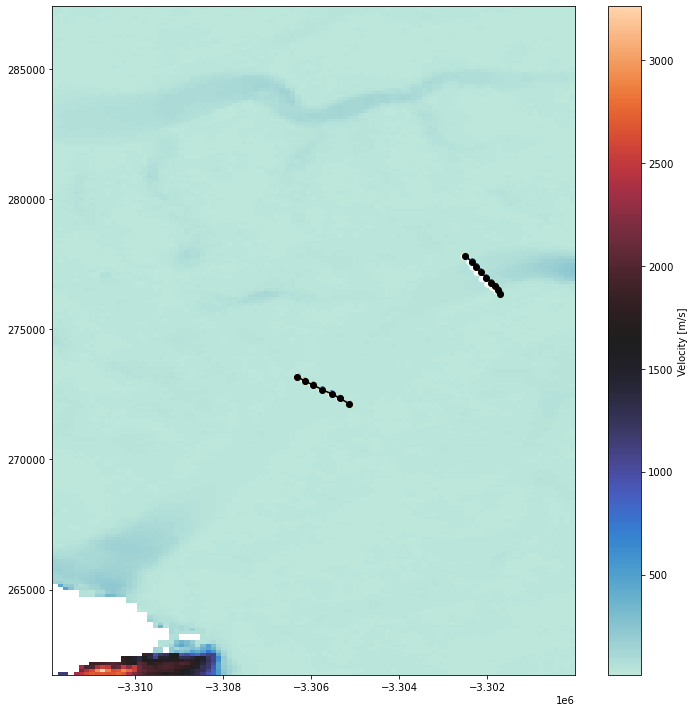

In [50]:
import matplotlib.pyplot as plt

# Used for the colors of the scatter plots
time = np.arange(0,len(ds.time))
# Background image
prog = np.nanmean(ds.v.values, axis = 0)

# plot the displacement of points

plt.figure(figsize=(10,10))
plt.pcolormesh(ds.x, ds.y, prog, cmap = 'icefire')
b = plt.colorbar()
b.set_label('Velocity [m/s]')

for i in range(0,n+1):
    for j in range(0, inds_nan[i]):
        plt.scatter(pts_total[i,:,j,0],pts_total[i,:,j,1], c=time, cmap = 'Blues_r')
    
    
    plt.plot(pts_total[i,0,:,0], pts_total[i,0,:,1],'-o', color='orange')
    plt.plot(pts_total[i,-2,:,0], pts_total[i,-2,:,1],'-o', color='black')
